In [51]:
# Import required libraries and set hardware for model to use
import torch
import pandas as pd
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from tqdm import tqdm
import gc

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

cuda


In [7]:
!pip freeze | grep transformers

sentence-transformers==3.3.1
transformers==4.47.1


## Loading the model

In [3]:
# Load images
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

print(image1)

<PIL.Image.Image image mode=RGB size=1600x1067 at 0x7E2FE3B0D060>


In [4]:
# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


config.json:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [11]:
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "describe the image in detail"}
        ]
    },
]


In [12]:
# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs = inputs.to(DEVICE)

# print(inputs)

In [13]:

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])


User:<image>describe the image in detail
Assistant: The image depicts a panoramic view of New York City, specifically focusing on the Statue of Liberty and the surrounding urban landscape. The foreground is dominated by the Statue of Liberty, a prominent symbol of freedom and democracy. The statue is depicted in a green patina, with her right arm raised, holding a torch. The statue stands on a pedestal, which is surrounded by water, with a small island in the foreground. The water is calm and still, reflecting the light from the sky.

In the background, the cityscape is visible, with numerous skyscrapers and high-rise buildings. The buildings are primarily made of glass and steel, with some having distinctive architectural designs. The sky is clear, with a gradient from light blue at the top to a darker blue at the bottom, indicating either sunrise or sunset.

The Statue of Liberty is positioned slightly to the left of the frame, with the Empire State Building and other notable buildin

## Prompt Tuning to do OCR on image

In [22]:
# prompt: unzip the ./dataset.zip file

# !unzip ./dataset.zip
# !rm -rf __MACOSX

In [32]:
aug_df = pd.read_csv("web_scraped_memes.csv")

In [33]:
aug_df.head()

,image_path,label,width,height,image_hash,duplicate
0,./dataset/violence against women meme offensiv...,1,575,500,421ba6dc0f109c51b090ca04509bce33,1
1,./dataset/violence against women meme offensiv...,1,600,600,aa4d925a75427431921a06ea8729acf5,1
2,./dataset/violence against women meme offensiv...,1,1200,1095,0d8a65051e1764e421af5fc897dd7ed8,0
3,./dataset/violence against women meme offensiv...,1,736,913,275ab8de6b3f9f53fb9fb9f3f18f2b4e,1
4,./dataset/violence against women meme offensiv...,1,600,692,8b32de0a2b61316aa3b5cda81dcd9fa8,1


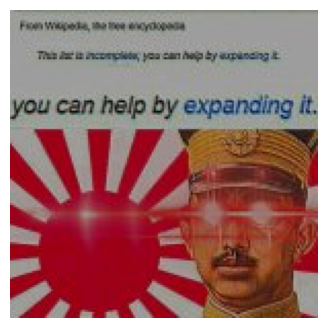

In [39]:
img_path = aug_df.iloc[200, 0]
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [44]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Extract all the meme text from the provided image."}
        ]
    },
]


test_img = load_image(img_path)
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[test_img], return_tensors="pt")
inputs = inputs.to(DEVICE)

generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

User:<image>Extract all the meme text from the provided image.
Assistant: From Wikipedias, the free encyclopedia. This bar is incomplete; you can help by expanding it. You can help by expanding it.


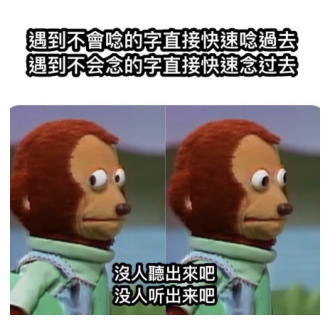

User:<image>Extract all the meme text from the provided image.
Assistant: 不知道什么鬼话，他们只是在说话，我们只是在看。


In [60]:
img_path = '/content/Screenshot 2025-01-08 at 5.59.07 PM.png'
img = mpimg.imread(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Extract all the meme text from the provided image."}
        ]
    },
]


test_img = load_image(img_path)
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[test_img], return_tensors="pt")
inputs = inputs.to(DEVICE)

generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

print(generated_texts[0])

Result for Image 1: User:<image>Extract all the text from the provided meme image, including captions, dialogues, or any textual content.
Assistant: Stay in drugs, eat your school and don't do vegetables.
Result for Image 2: User:<image>Extract all the text from the provided meme image, including captions, dialogues, or any textual content.
Assistant: What kids think communism is.
Result for Image 3: User:<image>Extract all the text from the provided meme image, including captions, dialogues, or any textual content.
Assistant: Did you know all war crimes are legal only if you win.
Result for Image 4: User:<image>Extract all the text from the provided meme image, including captions, dialogues, or any textual content.
Assistant: This is the homophobe flag.
Result for Image 5: User:<image>Extract all the text from the provided meme image, including captions, dialogues, or any textual content.
Assistant: People who judge you for the colour of your skin...aliens!


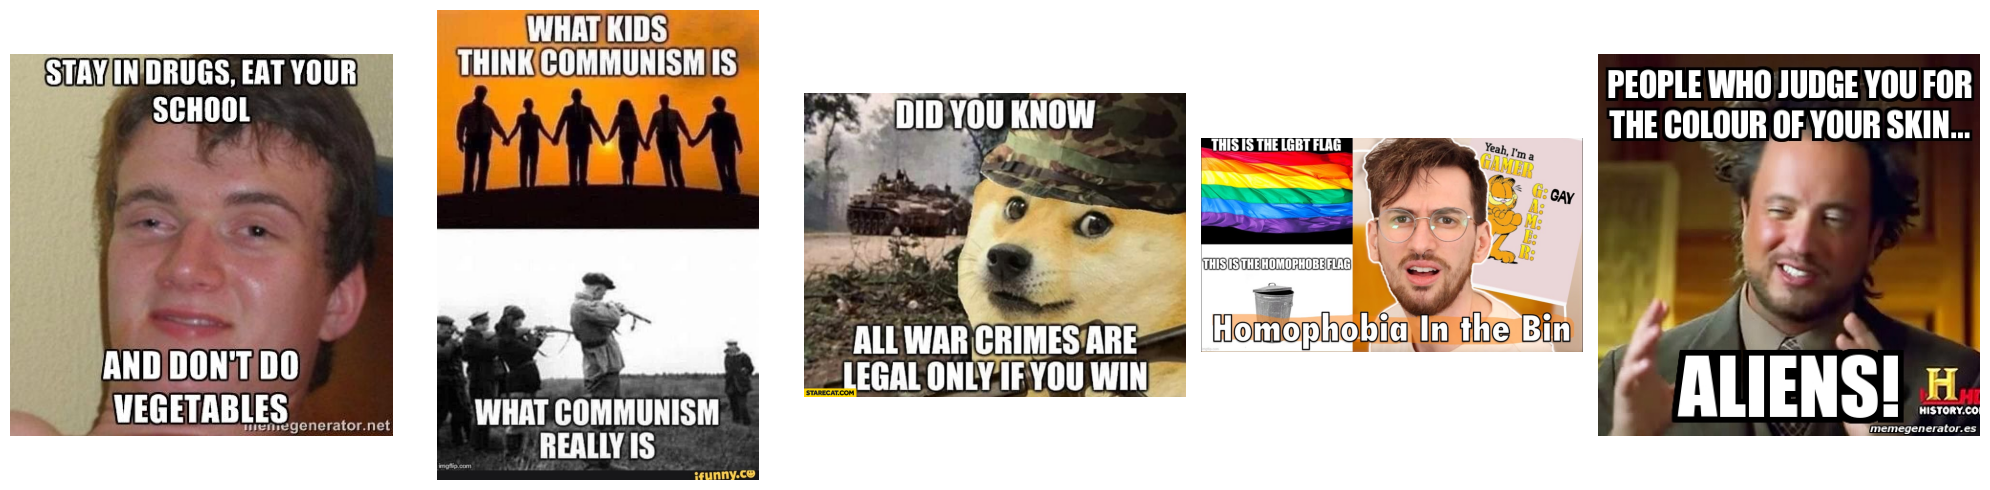

In [48]:
# testing on more examples to see if it is truely accurate

# Pick 5 random image paths from the dataframe
random_indices = random.sample(range(len(aug_df)), 5)
random_images = [aug_df.iloc[idx, 0] for idx in random_indices]

# Setup for inference model (assuming processor and model are defined)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Extract all the text from the provided meme image, including captions, dialogues, or any textual content."}
        ]
    },
]

# Create a 1x5 subplot to display the images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Loop through the images and perform inference
for idx, img_path in enumerate(random_images):
    # Load the image
    img = mpimg.imread(img_path)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Prepare input for model and process it
    test_img = load_image(img_path)
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[test_img], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Perform inference
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    # Print the result below the image
    print(f"Result for Image {idx + 1}: {generated_texts[0]}")

# Show the subplot with all images
plt.tight_layout()
plt.show()

## Running the VLM on all the images in the dataset

In [50]:
def extract_meme_text_from_image(image_path, model, processor, DEVICE):
    test_img = load_image(image_path)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Extract all the meme text from the provided image."}
            ]
        },
    ]

    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[test_img], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    try:
        generated_ids = model.generate(**inputs, max_new_tokens=500)

        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        return generated_texts[0]

    finally:
        # Clear GPU cache and perform garbage collection
        torch.cuda.empty_cache()
        gc.collect()

In [52]:
def process_meme_texts(df, model, processor, DEVICE, start_index=0):
    for idx, row in tqdm(df.iloc[start_index:].iterrows(), desc="text extracted", unit='meme'):
        image_path = row['image_path']
        status = row.get('status', 'not_processed')

        if status == 'processed':
            continue

        try:
            df.at[idx, 'status'] = 'in_progress'
            meme_text = extract_meme_text_from_image(image_path, model, processor, DEVICE)
            df.at[idx, 'meme_text'] = meme_text
            df.at[idx, 'status'] = 'processed'

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            df.at[idx, 'status'] = 'error'

        df.to_csv("aug_df_progress.csv", index=False)

    return df

In [ ]:
aug_df['meme_text'] = aug_df.get('meme_text', '')
aug_df['status'] = aug_df.get('status', 'not_processed')

if 'status' in aug_df.columns:
    last_processed_index = aug_df[aug_df['status'] == 'processed'].index[-1] if not aug_df[aug_df['status'] == 'processed'].empty else 0
else:
    last_processed_index = 0

aug_df = process_meme_texts(aug_df, model, processor, DEVICE, start_index=last_processed_index)
aug_df.to_csv('aug_df_with_meme_texts.csv', index=False)

text extracted: 102meme [13:58,  7.74s/meme]

Error processing image ./dataset/fake conspiracy theories meme offensive/Image_3.jpg: Incorrect image source. Must be a valid URL starting with `http://` or `https://`, a valid path to an image file, or a base64 encoded string. Got ./dataset/fake conspiracy theories meme offensive/Image_3.jpg. Failed with Incorrect padding


text extracted: 1391meme [3:14:33,  8.57s/meme]